# Verificando a Eficiência dos Filtros

# Antes de rodar o projeto, instale o tesseract na sua máquina, por favor.

In [31]:
%pip install pytesseract
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [32]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

import cv2
import matplotlib.pyplot as plt

### Primeiro, vamos criar um método para avaliar a confiança do Tesseract na detecção de texto em cada imagem.

In [33]:
from pytesseract import Output

def check_confidence(img):
    """
    Retorna a confiança do Tesseract em que o texto real está na imagem.
    Retorna um valor de 0-100 que corresponde à certeza de que o texto foi detectado na imagem.
    -1 significa que não encontrou texto.
    """

    custom_config = r"--psm 7"
    
    ocr_data = pytesseract.image_to_data(
        img,
        output_type=Output.DICT,
        config=custom_config
    )
    
    recognized_text_parts = []
    n_boxes = len(ocr_data['text'])
    found_text = False  # Flag para verificar se algum texto foi encontrado
    
    for i in range(n_boxes):
        # Remove caracteres fora de ASCII (por segurança)
        raw_text = ocr_data['text'][i]
        text = ''.join(c for c in raw_text if ord(c) < 128).strip()
        
        # Converte a confiança para inteiro (ou -1 se não conseguir)
        conf_val = ocr_data['conf'][i]
        if isinstance(conf_val, int):
            conf = conf_val
        else:
            try:
                conf = int(conf_val)
            except ValueError:
                conf = -1
        
        if text != "":
            found_text = True
            print(f"  - Texto detectado: '{text}', Conf: {conf}")
    
    if not found_text:
        print("Nenhum texto foi detectado na imagem.")


### Exibindo a imagem de exemplo para análise

Text(0.5, 1.0, 'Imagem Original')

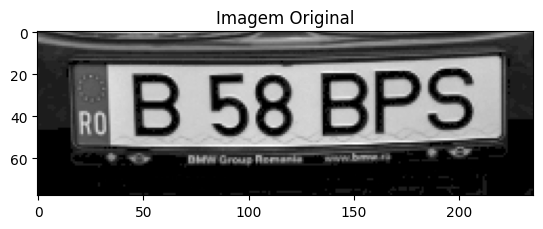

In [34]:
img = cv2.imread("placa1.png", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title('Imagem Original')

### Testando a confiança do Tesseract na imagem original, sem alterações

In [35]:
#Checa a confiança do tesseract
check_confidence(img)

  - Texto detectado: '[5', Conf: 15
  - Texto detectado: '58', Conf: 93
  - Texto detectado: 'BPS', Conf: 93


### Observamos que o texto foi parcialmente reconhecido: a letra "B" não foi detectada, enquanto o restante foi identificado corretamente. Vamos aplicar os filtros mencionados anteriormente para melhorar a detecção.

In [36]:
# Aplicando o filtro MedianBlur para suavizar a imagem.
"""
O filtro da mediana é usado para reduzir o ruído em uma imagem, preservando as bordas.
Ele substitui o valor de cada pixel pelo valor mediano dos pixels vizinhos em uma janela definida,
o que é especialmente útil para remover ruídos como o "sal e pimenta".
"""
blur = cv2.medianBlur(img, 3)

In [37]:
check_confidence(blur)

Nenhum texto foi detectado na imagem.


In [38]:
# Aplicando o limiar na imagem original (img) e na imagem suavizada (blur)
"""
O método cv2.threshold é usado para binarizar a imagem.
No caso da imagem original (img), utilizamos um limiar fixo de 127.
Para a imagem suavizada (blur), utilizamos o método Otsu (cv2.THRESH_OTSU), 
que determina automaticamente o melhor valor de limiar para binarizar a imagem.
O resultado são imagens binarizadas (binarizada e binarizada_blur), onde os pixels são 0 ou 255.
"""
_, binarizada = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
_, binarizada_blur = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [39]:
check_confidence(binarizada)
print('------------------')
check_confidence(binarizada_blur)

  - Texto detectado: 'B58', Conf: 39
  - Texto detectado: 'BPS', Conf: 88
------------------
Nenhum texto foi detectado na imagem.


In [40]:
# Criando um elemento estruturante retangular de 3x3
"""
O elemento estruturante é usado para definir a forma e o tamanho da operação morfológica.
Neste caso, estamos criando um kernel retangular de 3x3.
"""
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Aplicando a operação de abertura na imagem binarizada
"""
A operação de abertura é composta por uma erosão seguida de uma dilatação.
Ela é útil para remover pequenos objetos do primeiro plano (brancos) em uma imagem binária,
enquanto preserva a forma e o tamanho dos objetos maiores.
"""
aberta = cv2.morphologyEx(binarizada_blur, cv2.MORPH_OPEN, kernel)

In [41]:
check_confidence(aberta)

  - Texto detectado: 'B58', Conf: 64
  - Texto detectado: 'BPS]', Conf: 64


In [42]:
#Extrair somente o contorno das letras e numeros presentes na imagem da placa
"""
A operação de fechamento é composta por uma dilatação seguida de uma erosão.
Ela é útil para preencher pequenos buracos dentro dos objetos do primeiro plano (brancos) em uma imagem binária,
enquanto preserva a forma e o tamanho dos objetos maiores.
"""
fechada = cv2.morphologyEx(binarizada, cv2.MORPH_CLOSE, kernel)




In [43]:
check_confidence(fechada)

  - Texto detectado: 'AB', Conf: 44
  - Texto detectado: '58', Conf: 82
  - Texto detectado: 'BPS', Conf: 92


In [44]:
# Aplicando o filtro Canny para detecção de bordas na imagem suavizada.
"""
O filtro Canny é usado para detectar bordas em uma imagem. Ele funciona identificando áreas de transição abrupta de intensidade de pixel, 
como as bordas de objetos ou texto. Ao aplicar este filtro, destacamos as bordas mais significativas, 
o que pode ajudar o Tesseract a identificar melhor os contornos do texto.
Os parâmetros 15 e 100 representam os limites inferior e superior para a detecção de bordas.
"""
edges_abertura = cv2.Canny(aberta, 15, 100)
check_confidence(edges_abertura)
print("----------------------------------------------")
edges_fechada = cv2.Canny(fechada, 15, 100)
check_confidence(edges_fechada)



  - Texto detectado: '{858', Conf: 56
  - Texto detectado: 'BPS)', Conf: 79
----------------------------------------------
  - Texto detectado: '{BSS', Conf: 35
  - Texto detectado: 'EPS', Conf: 75


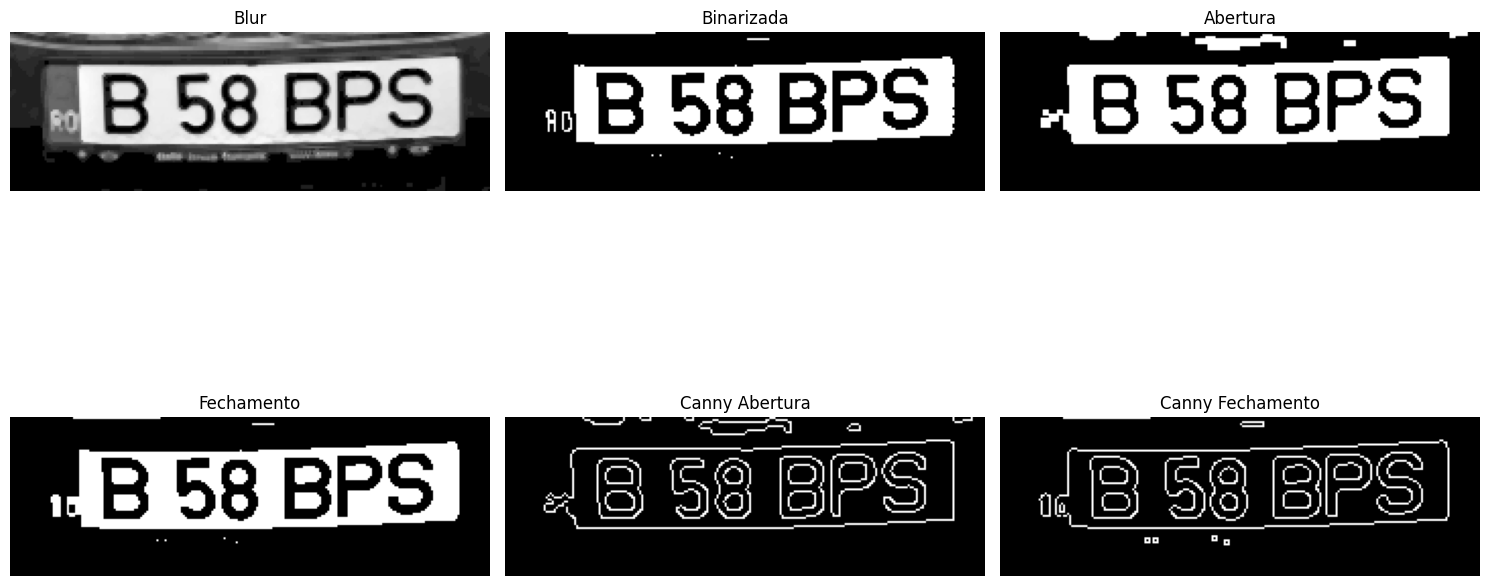

In [45]:
# exiba todas as imagens aberta, fechada, edges_abertura e edges_fechada
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(blur, cmap='gray')
plt.title('Blur')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(binarizada, cmap='gray')
plt.title('Binarizada')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(aberta, cmap='gray')
plt.title('Abertura')
plt.axis('off')
plt.subplot(2, 3, 4)
plt.imshow(fechada, cmap='gray')
plt.title('Fechamento')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(edges_abertura, cmap='gray')
plt.title('Canny Abertura')
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(edges_fechada, cmap='gray')
plt.title('Canny Fechamento')
plt.axis('off')
plt.tight_layout()
plt.show()


### Após aplicar filtros de suavização e detecção de bordas, identificamos que a melhor saída foi obtida utilizando a imagem convertida para sua forma binária por meio de threshold da imagem original.